In [1]:
import os
import torch
import itertools
import numpy as np
import torch.nn as nn
from PIL import Image
import torch.utils.data
import torch.nn.parallel
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.datasets as dset
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision import transforms
from typing import List, Tuple, Dict
from tqdm import tqdm
import random
from scipy.linalg import sqrtm

In [2]:
# Decide which device we want to run on
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


In [3]:
# Define a classe de transformação
class Transform:
    def __init__(self):
        self.data_transform = transforms.Compose([transforms.ToTensor()])

    def __call__(self, inp):
        return self.data_transform(inp)

# Define a classe SeismicDataset para carregar dados binários
class SeismicDataset:
    def __init__(self, elastic_folder, acoustic_folder, shape=(256, 256, 1)):
        self.elastic_files = sorted([os.path.join(elastic_folder, f) for f in os.listdir(elastic_folder) if f.endswith('.bin')])
        self.acoustic_files = sorted([os.path.join(acoustic_folder, f) for f in os.listdir(acoustic_folder) if f.endswith('.bin')])
        self.transformer = Transform()

        # Define o tamanho dos patches com base no parâmetro `shape`
        self.patch_shape = shape

        # Verifica se o número de patches é o mesmo em ambas as pastas
        assert len(self.elastic_files) == len(self.acoustic_files), "Número de patches deve ser igual em ambas as pastas."

    def __len__(self):
        return len(self.elastic_files)

    def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor]:
        # Carrega os patches binários para elastic e acoustic
        elastic_patch = np.fromfile(self.elastic_files[idx], dtype='float32').reshape(self.patch_shape)
        acoustic_patch = np.fromfile(self.acoustic_files[idx], dtype='float32').reshape(self.patch_shape)
        
        # Transforma para tensor
        elastic_patch = self.transformer(elastic_patch)
        acoustic_patch = self.transformer(acoustic_patch)

        return acoustic_patch, elastic_patch


# Define as pastas de treino e teste
train_elastic_path = r'C:\Users\Matheus\TrabalhodeMestrado\Redes_Neurais\Dados\Seismic_data_set\train\elastic_vz'
train_acoustic_path = r'C:\Users\Matheus\TrabalhodeMestrado\Redes_Neurais\Dados\Seismic_data_set\train\acoustic'
test_elastic_path = r'C:\Users\Matheus\TrabalhodeMestrado\Redes_Neurais\Dados\Seismic_data_set\test\elastic_vz'
test_acoustic_path = r'C:\Users\Matheus\TrabalhodeMestrado\Redes_Neurais\Dados\Seismic_data_set\test\acoustic'

# Cria o dataset e DataLoader para treino e teste
train_ds = SeismicDataset(train_elastic_path, train_acoustic_path, shape=(256, 256, 1))
test_ds = SeismicDataset(test_elastic_path, test_acoustic_path, shape=(768, 361, 1))

# Parâmetros do DataLoader
BATCH_SIZE_TRAIN = 4
BATCH_SIZE_TEST = 1

# DataLoaders
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE_TRAIN, shuffle=True, drop_last=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE_TEST, shuffle=False, drop_last=False)

print("DataLoaders de treino e teste criados com sucesso!")

DataLoaders de treino e teste criados com sucesso!


In [4]:
# Número total de patches no dataset de treino
num_train_patches = len(train_ds)
num_test_patches = len(test_ds)

# Número de batches no DataLoader
num_train_batches = len(train_dl)
num_test_batches = len(test_dl)

print(f"Número total de patches de treino: {num_train_patches}")
print(f"Número total de patches de teste: {num_test_patches}")
print(f"Número total de batches de treino: {num_train_batches}")
print(f"Número total de batches de teste: {num_test_batches}")

Número total de patches de treino: 3000
Número total de patches de teste: 61
Número total de batches de treino: 750
Número total de batches de teste: 61


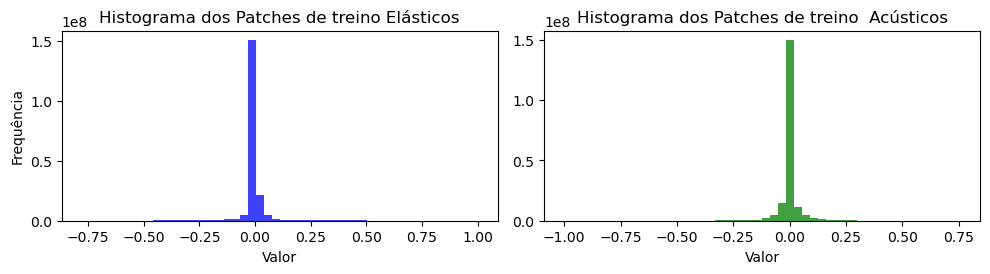

In [5]:
# Inicializar listas para armazenar os valores de todos os patches
all_elastic_values = []
all_acoustic_values = []

# Iterar sobre todo o DataLoader
for elastic_patch, acoustic_patch in train_dl:
    all_elastic_values.append(elastic_patch.numpy().flatten())
    all_acoustic_values.append(acoustic_patch.numpy().flatten())

# Concatenar todos os valores de todos os patches em um único array
all_elastic_values = np.concatenate(all_elastic_values)
all_acoustic_values = np.concatenate(all_acoustic_values)

# Plotar o histograma para os patches elásticos e acústicos
plt.figure(figsize=(10, 3))

# Histograma para os patches elásticos
plt.subplot(1, 2, 1)
plt.hist(all_elastic_values, bins=50, alpha=0.75, color='blue')
plt.title('Histograma dos Patches de treino Elásticos')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Histograma para os patches acústicos
plt.subplot(1, 2, 2)
plt.hist(all_acoustic_values, bins=50, alpha=0.75, color='green')
plt.title('Histograma dos Patches de treino  Acústicos')
plt.xlabel('Valor')

# Mostrar os gráficos
plt.tight_layout()
plt.show()

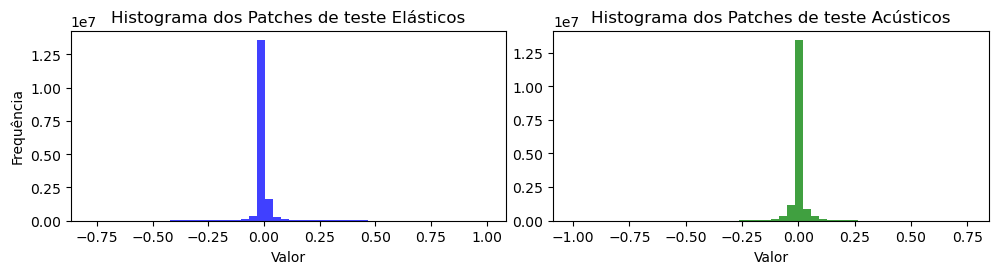

In [6]:
# Inicializar listas para armazenar os valores de todos os patches
all_elastic_values = []
all_acoustic_values = []

# Iterar sobre todo o DataLoader
for elastic_patch, acoustic_patch in test_dl:
    all_elastic_values.append(elastic_patch.numpy().flatten())
    all_acoustic_values.append(acoustic_patch.numpy().flatten())

# Concatenar todos os valores de todos os patches em um único array
all_elastic_values = np.concatenate(all_elastic_values)
all_acoustic_values = np.concatenate(all_acoustic_values)

# Plotar o histograma para os patches elásticos e acústicos
plt.figure(figsize=(10, 3))

# Histograma para os patches elásticos
plt.subplot(1, 2, 1)
plt.hist(all_elastic_values, bins=50, alpha=0.75, color='blue')
plt.title('Histograma dos Patches de teste Elásticos')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Histograma para os patches acústicos
plt.subplot(1, 2, 2)
plt.hist(all_acoustic_values, bins=50, alpha=0.75, color='green')
plt.title('Histograma dos Patches de teste Acústicos')
plt.xlabel('Valor')

# Mostrar os gráficos
plt.tight_layout()
plt.show()

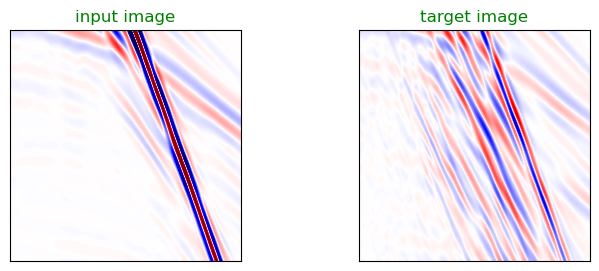

In [7]:
def show_img_sample(train_dl):
    for i, (real_input, real_target) in enumerate(train_dl):
        if i > 0:
            break
        fig, axes = plt.subplots(1, 2, figsize=(9, 3))
        ax = axes.ravel()
        
        perc = 99
        vmax = np.percentile(np.abs(real_input[0].squeeze()), perc)
        vmin = -vmax
        
        ax[0].imshow(real_input[0].squeeze(), cmap='seismic', vmin=vmin, vmax=vmax)
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].set_title("input image", c="g")
        ax[1].imshow(real_target[0].squeeze(), cmap='seismic', vmin=vmin, vmax=vmax)
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[1].set_title("target image", c="g")
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()

show_img_sample(train_dl)

In [8]:
class GeneratorUnet(nn.Module):
    def __init__(self, in_channels):
        super(GeneratorUnet, self).__init__()
        self.down_stack = nn.ModuleList([
            self.Downsample(in_channels, 64, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
            self.Downsample(64, 128),  # (batch_size, 64, 64, 128)
            self.Downsample(128, 256),  # (batch_size, 32, 32, 256)
            self.Downsample(256, 512),  # (batch_size, 16, 16, 512)
            self.Downsample(512, 512),  # (batch_size, 8, 8, 512)
            self.Downsample(512, 512),  # (batch_size, 4, 4, 512)
            self.Downsample(512, 512),  # (batch_size, 2, 2, 512)
            self.Downsample(512, 512, apply_batchnorm=False),  # (batch_size, 1, 1, 512)
        ])

        self.up_stack = nn.ModuleList([
            self.Upsample(512, 512, apply_dropout=True),  # (batch_size, 2, 2, 1024)
            self.Upsample(1024, 512, apply_dropout=True),  # (batch_size, 4, 4, 1024)
            self.Upsample(1024, 512, apply_dropout=True),  # (batch_size, 8, 8, 1024)
            self.Upsample(1024, 512),  # (batch_size, 16, 16, 1024)
            self.Upsample(1024, 256),  # (batch_size, 32, 32, 512)
            self.Upsample(512, 128),  # (batch_size, 64, 64, 256)
            self.Upsample(256, 64),  # (batch_size, 128, 128, 128)
        ])

        self.last = nn.ConvTranspose2d(128, in_channels, kernel_size=4, stride=2, padding=1, bias=False)
        self.tanh = nn.Tanh()

    def Downsample(self, in_channels, out_channels, apply_batchnorm=True):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        if apply_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))

        return nn.Sequential(*layers)

    def Upsample(self, in_channels, out_channels, apply_dropout=False):
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(inplace=True)
        ]
        if apply_dropout:
            layers.append(nn.Dropout(0.5))

        return nn.Sequential(*layers)

    def forward(self, x):
        skips = []
        for down in self.down_stack:
            x = down(x)
            skips.append(x)

        skips = reversed(skips[:-1])
        
        for up, skip in zip(self.up_stack, skips):
            x = up(x)
            x = torch.cat([x, skip], dim=1)

        x = self.last(x)
        x = self.tanh(x)
        return x

In [9]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            *self.block(in_channels, 64, normalize=False, apply_dropout=False), # 3*256*256 -> 64*128*128 
            *self.block(64, 128),  # 64*128*128 -> 128*64*64
            *self.block(128, 256), # 128*64*64 -> 256*32*32     
            nn.ZeroPad2d(1), # padding left and top   256*32*32 -> 256*34*34
            nn.Conv2d(256, 512, kernel_size=4, stride=1, bias=False), #256*34*34 -> 512*31*31
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ZeroPad2d(1), #512*31*31 -> 512*33*33
            nn.Conv2d(512, 1, kernel_size=4) #512*33*33 -> 1*30*30
        )
    
    @staticmethod
    def block(in_channels, out_channels, normalize=True, apply_dropout=True):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return layers
        
    def forward(self, input, target):
        x = torch.cat((input, target), dim=1)
        return self.model(x)

In [10]:
criterion_L1  = nn.L1Loss() # Perda L1
criterion_GAN = nn.BCEWithLogitsLoss() 
#criterion_GAN = nn.MSELoss()

In [11]:
G = GeneratorUnet(1)
D = Discriminator(2)

In [12]:
cuda = torch.cuda.is_available()
print(f'cuda: {cuda}')

if cuda:
    G = G.cuda()
    D = D.cuda()
    
    criterion_L1 = criterion_L1.cuda()
    criterion_GAN = criterion_GAN.cuda()

cuda: True


In [13]:
def visualize_data(generator, discriminator, dataloader, title, device):
    generator.eval()  # Coloca o gerador no modo de avaliação
    discriminator.eval()  # Coloca o discriminador no modo de avaliação

    # Itera através do dataloader
    for i, (real_input, real_target) in enumerate(dataloader):
        if i > 0:
          break

        real_input, real_target = real_input.to(device), real_target.to(device)

        # Gera imagens falsas com o gerador
        with torch.no_grad():
            fake_image = generator(real_input)

        # Avalia as imagens reais e falsas com o discriminador
        real_output = discriminator(real_input,real_target)
        fake_output = discriminator(real_input,fake_image.detach())

        print(f'shape da saída do gerador {fake_image.shape}')
        print(f'shape da saída do discriminador {fake_output.shape}')

        # Visualiza os resultados
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f'{title}')

        real_input_img = real_input[0].squeeze().cpu()
        real_target_img = real_target[0].squeeze().cpu()
        fake_image_img = fake_image[0].squeeze().cpu()

        perc = 99
        vmax = np.percentile(np.abs(real_input_img), perc)
        vmin = -vmax

       # Mostra a imagem de entrada (real)
        im1 = ax[0].imshow(real_input_img, cmap='seismic',vmin=vmin, vmax=vmax)
        ax[0].set_title('Real Input', c="g")
        ax[0].axis('off')

        # Mostra a imagem real alvo (ground truth)
        im2 = ax[1].imshow(real_target_img, cmap='seismic',vmin=vmin, vmax=vmax)
        ax[1].set_title('Real Target', c="g")
        ax[1].axis('off')

        # Mostra a imagem falsa gerada
        im3 = ax[2].imshow(fake_image_img, cmap='seismic',vmin=vmin, vmax=vmax)
        ax[2].set_title('Generated Image', c="g")
        ax[2].axis('off')

        plt.tight_layout()
        plt.show()

shape da saída do gerador torch.Size([4, 1, 256, 256])
shape da saída do discriminador torch.Size([4, 1, 30, 30])


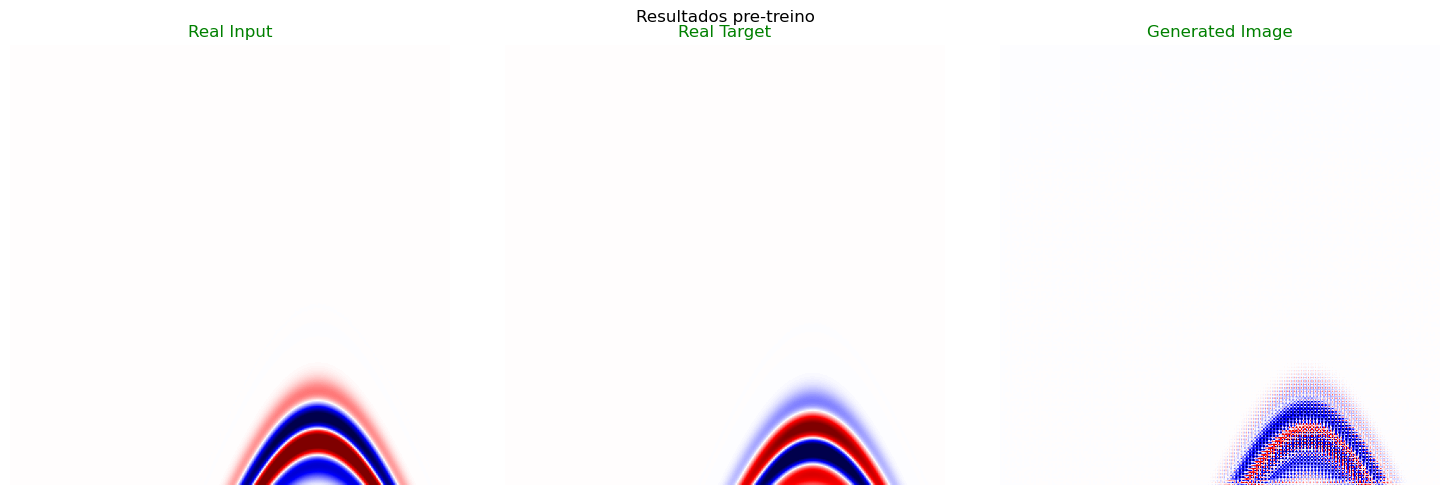

In [14]:
visualize_data(G, D, train_dl, 'Resultados pre-treino', device)

In [15]:
lr_G = 2e-4
lr_D = 2e-4
b1 = 0.5
b2 = 0.999

optimizer_G = torch.optim.Adam(G.parameters(), lr=lr_G, betas=(b1, b2))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr_D, betas=(b1, b2))

In [16]:
n_epoches = 150
decay_epoch = 40 # Reference paper
G_losses, D_losses, L1_losses, GAN_losses = [], [], [], []

lambda_func = lambda epoch: 1 - max(0, epoch-decay_epoch)/(n_epoches-decay_epoch)
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_func)
lr_scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_D, lr_lambda=lambda_func)

for epoch in range(n_epoches):

    G.train()
    D.train()
    LAMBDA = 1000

    for i, (input, target) in enumerate(tqdm(train_dl)):
        it = i+1
        input, target = input.to(device), target.to(device)

        real_label = torch.ones_like(D(input, target), device=device)  # Rótulo para imagens reais
        fake_label = torch.zeros_like(D(input, target), device=device) 
        
        fake_image = G(input)
        fake_image_ = fake_image.detach()

        """Train Generators"""
        # set to training mode in the begining, because sample_images will set it to eval mode

        optimizer_G.zero_grad()

        # GAN loss, train G to make D think it's true
        loss_L1 = criterion_L1(fake_image, target)
        loss_GAN = criterion_GAN(D(input, fake_image), real_label) # Não pode usar o fake_image_ aqui, pois o gerador precisa calcular o gradiente com basse na imagem fake
        
        # G total loss
        loss_G = loss_GAN + LAMBDA * loss_L1 

        loss_G.backward()
        optimizer_G.step()

        if it % 4 == 0:
        
            """Train Discriminator """
            optimizer_D.zero_grad()
            
            loss_real = criterion_GAN(D(input, target), real_label)
            loss_fake = criterion_GAN(D(input, fake_image_), fake_label)
            loss_D = (loss_real + loss_fake) * 0.5
            
            loss_D.backward()
            optimizer_D.step()
    
    lr_scheduler_G.step()
    lr_scheduler_D.step()

    # Salvar as perdas para cada época
    G_losses.append(loss_G.item())
    D_losses.append(loss_D.item())
    GAN_losses.append(loss_GAN.item())
    L1_losses.append(loss_L1.item())

    print(f'[Epoch {epoch + 1}/{n_epoches}]')
    print(f'[G loss: {loss_G.item()} | GAN: {loss_GAN.item()} L1: {loss_L1.item()}]')
    print(f'[D loss: {loss_D.item()}]')

100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.17it/s]


[Epoch 1/150]
[G loss: 10.296859741210938 | GAN: 1.1060162782669067 L1: 0.009190843440592289]
[D loss: 0.4920808970928192]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.82it/s]


[Epoch 2/150]
[G loss: 17.131763458251953 | GAN: 0.8588280081748962 L1: 0.016272936016321182]
[D loss: 0.5908664464950562]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.21it/s]


[Epoch 3/150]
[G loss: 4.919121742248535 | GAN: 0.7713050842285156 L1: 0.004147816449403763]
[D loss: 0.5202077627182007]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.22it/s]


[Epoch 4/150]
[G loss: 2.3268496990203857 | GAN: 0.8645626306533813 L1: 0.0014622870367020369]
[D loss: 0.6769765615463257]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.20it/s]


[Epoch 5/150]
[G loss: 1.8415133953094482 | GAN: 0.9611799716949463 L1: 0.0008803334785625339]
[D loss: 0.623894453048706]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.17it/s]


[Epoch 6/150]
[G loss: 1.9244740009307861 | GAN: 0.8440501689910889 L1: 0.0010804238263517618]
[D loss: 0.5477344989776611]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.23it/s]


[Epoch 7/150]
[G loss: 4.620053768157959 | GAN: 1.1127783060073853 L1: 0.0035072755999863148]
[D loss: 0.6461254954338074]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.24it/s]


[Epoch 8/150]
[G loss: 2.6122944355010986 | GAN: 0.6058559417724609 L1: 0.002006438560783863]
[D loss: 0.6558827757835388]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.21it/s]


[Epoch 9/150]
[G loss: 4.864736080169678 | GAN: 0.7077625393867493 L1: 0.004156973212957382]
[D loss: 0.6534363031387329]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.10it/s]


[Epoch 10/150]
[G loss: 1.8057541847229004 | GAN: 0.921302318572998 L1: 0.0008844517869874835]
[D loss: 0.6414427757263184]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.23it/s]


[Epoch 11/150]
[G loss: 4.766391754150391 | GAN: 2.019239902496338 L1: 0.0027471520006656647]
[D loss: 0.6119862198829651]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.17it/s]


[Epoch 12/150]
[G loss: 2.8718461990356445 | GAN: 1.0527187585830688 L1: 0.0018191274721175432]
[D loss: 0.6665678024291992]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.18it/s]


[Epoch 13/150]
[G loss: 2.437457799911499 | GAN: 0.776847779750824 L1: 0.0016606100834906101]
[D loss: 0.6846503615379333]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.23it/s]


[Epoch 14/150]
[G loss: 2.0454494953155518 | GAN: 0.2988061308860779 L1: 0.0017466434510424733]
[D loss: 0.746181845664978]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.23it/s]


[Epoch 15/150]
[G loss: 1.1640698909759521 | GAN: 0.7108396291732788 L1: 0.0004532303137239069]
[D loss: 0.7719737887382507]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.21it/s]


[Epoch 16/150]
[G loss: 3.5340635776519775 | GAN: 0.6772482991218567 L1: 0.0028568152338266373]
[D loss: 0.6634320020675659]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.21it/s]


[Epoch 17/150]
[G loss: 2.296433925628662 | GAN: 0.9451981782913208 L1: 0.0013512359000742435]
[D loss: 0.6660420298576355]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.24it/s]


[Epoch 18/150]
[G loss: 2.5394983291625977 | GAN: 0.7096449136734009 L1: 0.0018298535142093897]
[D loss: 0.6546975374221802]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.22it/s]


[Epoch 19/150]
[G loss: 2.900290012359619 | GAN: 0.682988703250885 L1: 0.0022173014003783464]
[D loss: 0.6955858469009399]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 15.99it/s]


[Epoch 20/150]
[G loss: 2.2459545135498047 | GAN: 0.6731026768684387 L1: 0.0015728517901152372]
[D loss: 0.684860348701477]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.56it/s]


[Epoch 21/150]
[G loss: 1.5945563316345215 | GAN: 0.7246733903884888 L1: 0.0008698829915374517]
[D loss: 0.6987438201904297]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.92it/s]


[Epoch 22/150]
[G loss: 2.406893730163574 | GAN: 0.6548016667366028 L1: 0.0017520921537652612]
[D loss: 0.8039693236351013]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:50<00:00, 14.93it/s]


[Epoch 23/150]
[G loss: 2.6790754795074463 | GAN: 0.7460409998893738 L1: 0.001933034393005073]
[D loss: 0.7046942710876465]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.52it/s]


[Epoch 24/150]
[G loss: 4.313261032104492 | GAN: 1.7415851354599 L1: 0.002571675693616271]
[D loss: 0.5699683427810669]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.52it/s]


[Epoch 25/150]
[G loss: 2.0388526916503906 | GAN: 0.7933388948440552 L1: 0.0012455137912184]
[D loss: 0.6960370540618896]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.60it/s]


[Epoch 26/150]
[G loss: 1.909074306488037 | GAN: 0.7561209201812744 L1: 0.001152953365817666]
[D loss: 0.6906430125236511]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.30it/s]


[Epoch 27/150]
[G loss: 2.4152963161468506 | GAN: 0.5659359097480774 L1: 0.0018493602983653545]
[D loss: 0.7063071131706238]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.67it/s]


[Epoch 28/150]
[G loss: 5.507802963256836 | GAN: 3.1876866817474365 L1: 0.0023201163858175278]
[D loss: 0.6455283761024475]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.71it/s]


[Epoch 29/150]
[G loss: 1.946967601776123 | GAN: 0.5891997218132019 L1: 0.001357767847366631]
[D loss: 0.681826651096344]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.74it/s]


[Epoch 30/150]
[G loss: 2.624598741531372 | GAN: 0.6047784686088562 L1: 0.0020198202691972256]
[D loss: 0.6724683046340942]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.86it/s]


[Epoch 31/150]
[G loss: 1.7454107999801636 | GAN: 0.7695755958557129 L1: 0.0009758351952768862]
[D loss: 0.6784250140190125]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.85it/s]


[Epoch 32/150]
[G loss: 5.347269058227539 | GAN: 3.4608871936798096 L1: 0.0018863821169361472]
[D loss: 0.2125948667526245]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.08it/s]


[Epoch 33/150]
[G loss: 2.406230926513672 | GAN: 0.7217716574668884 L1: 0.0016844591591507196]
[D loss: 0.672819972038269]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.34it/s]


[Epoch 34/150]
[G loss: 3.3580994606018066 | GAN: 2.330354928970337 L1: 0.0010277444962412119]
[D loss: 0.11820708215236664]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.54it/s]


[Epoch 35/150]
[G loss: 2.494387149810791 | GAN: 0.719584047794342 L1: 0.0017748031532391906]
[D loss: 0.7008106112480164]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.46it/s]


[Epoch 36/150]
[G loss: 3.4041826725006104 | GAN: 1.9194881916046143 L1: 0.0014846944250166416]
[D loss: 0.22443032264709473]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.62it/s]


[Epoch 37/150]
[G loss: 3.889693021774292 | GAN: 2.6980090141296387 L1: 0.0011916840448975563]
[D loss: 0.09324760735034943]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.40it/s]


[Epoch 38/150]
[G loss: 6.269641399383545 | GAN: 4.436932563781738 L1: 0.001832708832807839]
[D loss: 0.8869096040725708]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.63it/s]


[Epoch 39/150]
[G loss: 2.672152042388916 | GAN: 0.7036706209182739 L1: 0.001968481345102191]
[D loss: 0.6821215152740479]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.22it/s]


[Epoch 40/150]
[G loss: 3.884652614593506 | GAN: 3.0109517574310303 L1: 0.0008737008320167661]
[D loss: 0.20811140537261963]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.63it/s]


[Epoch 41/150]
[G loss: 2.919792890548706 | GAN: 0.7511089444160461 L1: 0.002168684033676982]
[D loss: 0.695000171661377]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.31it/s]


[Epoch 42/150]
[G loss: 1.9453401565551758 | GAN: 0.732006847858429 L1: 0.001213333336636424]
[D loss: 0.7687199115753174]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.64it/s]


[Epoch 43/150]
[G loss: 2.6982126235961914 | GAN: 0.6700162887573242 L1: 0.0020281963516026735]
[D loss: 0.7136985659599304]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.62it/s]


[Epoch 44/150]
[G loss: 3.4576284885406494 | GAN: 1.5614532232284546 L1: 0.0018961752066388726]
[D loss: 0.7787742614746094]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.40it/s]


[Epoch 45/150]
[G loss: 3.348094940185547 | GAN: 1.7775198221206665 L1: 0.001570574939250946]
[D loss: 0.1789744347333908]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.41it/s]


[Epoch 46/150]
[G loss: 1.5671265125274658 | GAN: 0.6599061489105225 L1: 0.0009072203538380563]
[D loss: 0.6936761140823364]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.60it/s]


[Epoch 47/150]
[G loss: 2.761086940765381 | GAN: 0.7369416356086731 L1: 0.00202414533123374]
[D loss: 0.6889184713363647]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.58it/s]


[Epoch 48/150]
[G loss: 1.0486528873443604 | GAN: 0.7508476376533508 L1: 0.00029780532349832356]
[D loss: 0.6657435894012451]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.58it/s]


[Epoch 49/150]
[G loss: 4.408517360687256 | GAN: 2.7080557346343994 L1: 0.00170046160928905]
[D loss: 0.19850783050060272]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.11it/s]


[Epoch 50/150]
[G loss: 1.7770978212356567 | GAN: 0.7598378658294678 L1: 0.0010172598995268345]
[D loss: 0.7682108879089355]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.40it/s]


[Epoch 51/150]
[G loss: 2.9715304374694824 | GAN: 1.6163380146026611 L1: 0.0013551923912018538]
[D loss: 0.02347870171070099]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.11it/s]


[Epoch 52/150]
[G loss: 2.326117515563965 | GAN: 0.7324091196060181 L1: 0.0015937084099277854]
[D loss: 0.7133823037147522]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.62it/s]


[Epoch 53/150]
[G loss: 2.058218240737915 | GAN: 0.6860823035240173 L1: 0.0013721358263865113]
[D loss: 0.695572018623352]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.08it/s]


[Epoch 54/150]
[G loss: 1.5844807624816895 | GAN: 0.7275215983390808 L1: 0.0008569591445848346]
[D loss: 0.6673166751861572]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:49<00:00, 15.20it/s]


[Epoch 55/150]
[G loss: 1.5449512004852295 | GAN: 0.30957311391830444 L1: 0.001235377974808216]
[D loss: 0.7007331252098083]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.74it/s]


[Epoch 56/150]
[G loss: 7.515688419342041 | GAN: 5.500258922576904 L1: 0.002015429548919201]
[D loss: 0.006712437607347965]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.77it/s]


[Epoch 57/150]
[G loss: 1.7314856052398682 | GAN: 0.985302209854126 L1: 0.0007461834466084838]
[D loss: 0.7232416868209839]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:48<00:00, 15.56it/s]


[Epoch 58/150]
[G loss: 4.928842544555664 | GAN: 3.7352874279022217 L1: 0.0011935551883652806]
[D loss: 0.23835602402687073]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.86it/s]


[Epoch 59/150]
[G loss: 1.4620009660720825 | GAN: 0.6011436581611633 L1: 0.0008608573116362095]
[D loss: 0.688336968421936]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.88it/s]


[Epoch 60/150]
[G loss: 8.655923843383789 | GAN: 6.646625995635986 L1: 0.0020092984195798635]
[D loss: 0.0063100215047597885]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.87it/s]


[Epoch 61/150]
[G loss: 2.167057991027832 | GAN: 0.7188909649848938 L1: 0.001448167022317648]
[D loss: 0.6958383321762085]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.86it/s]


[Epoch 62/150]
[G loss: 1.4615659713745117 | GAN: 0.7104489207267761 L1: 0.0007511170115321875]
[D loss: 0.6950744390487671]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.86it/s]


[Epoch 63/150]
[G loss: 2.1427412033081055 | GAN: 0.7079938650131226 L1: 0.0014347473625093699]
[D loss: 0.7022590041160583]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.87it/s]


[Epoch 64/150]
[G loss: 1.33781099319458 | GAN: 0.6933295130729675 L1: 0.0006444815080612898]
[D loss: 0.6542537212371826]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.87it/s]


[Epoch 65/150]
[G loss: 6.113545894622803 | GAN: 3.770287036895752 L1: 0.002343258820474148]
[D loss: 0.13369181752204895]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.76it/s]


[Epoch 66/150]
[G loss: 8.565954208374023 | GAN: 7.142729759216309 L1: 0.0014232241082936525]
[D loss: 0.02660268545150757]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 67/150]
[G loss: 3.746328353881836 | GAN: 2.204416513442993 L1: 0.0015419118572026491]
[D loss: 0.045793045312166214]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.06it/s]


[Epoch 68/150]
[G loss: 1.751214861869812 | GAN: 0.6687818765640259 L1: 0.0010824330383911729]
[D loss: 0.6504006385803223]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.06it/s]


[Epoch 69/150]
[G loss: 1.9193830490112305 | GAN: 0.7136724591255188 L1: 0.00120571069419384]
[D loss: 0.6976659893989563]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 70/150]
[G loss: 1.9861767292022705 | GAN: 0.6861545443534851 L1: 0.0013000222388654947]
[D loss: 0.6982097625732422]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 71/150]
[G loss: 1.7205452919006348 | GAN: 0.7094770073890686 L1: 0.0010110682342201471]
[D loss: 0.6939198970794678]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 72/150]
[G loss: 1.9705301523208618 | GAN: 0.7249263525009155 L1: 0.0012456037802621722]
[D loss: 0.6779686212539673]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 73/150]
[G loss: 7.944830894470215 | GAN: 5.790836811065674 L1: 0.0021539938170462847]
[D loss: 0.010739019140601158]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.06it/s]


[Epoch 74/150]
[G loss: 8.946904182434082 | GAN: 5.827215671539307 L1: 0.0031196882482618093]
[D loss: 0.006861991249024868]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 75/150]
[G loss: 1.494771957397461 | GAN: 0.7311282753944397 L1: 0.000763643765822053]
[D loss: 0.6980907917022705]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 76/150]
[G loss: 2.3967602252960205 | GAN: 1.4812378883361816 L1: 0.0009155223378911614]
[D loss: 0.6855998039245605]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 77/150]
[G loss: 1.3451917171478271 | GAN: 0.7065200805664062 L1: 0.000638671568594873]
[D loss: 0.6993873715400696]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.06it/s]


[Epoch 78/150]
[G loss: 1.9097933769226074 | GAN: 0.6903666853904724 L1: 0.0012194266309961677]
[D loss: 0.6967017650604248]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 79/150]
[G loss: 2.4518048763275146 | GAN: 0.6747952103614807 L1: 0.0017770095728337765]
[D loss: 0.7033292651176453]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 80/150]
[G loss: 6.759256362915039 | GAN: 5.290030479431152 L1: 0.0014692256227135658]
[D loss: 0.007549567613750696]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 81/150]
[G loss: 8.706070899963379 | GAN: 7.218693733215332 L1: 0.0014873770996928215]
[D loss: 0.008780967444181442]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.06it/s]


[Epoch 82/150]
[G loss: 3.0871989727020264 | GAN: 1.9773125648498535 L1: 0.0011098864488303661]
[D loss: 0.11585036665201187]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 83/150]
[G loss: 1.5701106786727905 | GAN: 0.7293043732643127 L1: 0.0008408062858507037]
[D loss: 0.6411905288696289]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 84/150]
[G loss: 5.687153339385986 | GAN: 4.493868827819824 L1: 0.0011932844063267112]
[D loss: 0.10848250985145569]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 85/150]
[G loss: 3.951080083847046 | GAN: 2.522597551345825 L1: 0.0014284825883805752]
[D loss: 0.08444005995988846]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.06it/s]


[Epoch 86/150]
[G loss: 7.968991756439209 | GAN: 6.585000038146973 L1: 0.0013839916791766882]
[D loss: 0.0035668686032295227]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 87/150]
[G loss: 2.4240736961364746 | GAN: 1.5042059421539307 L1: 0.0009198678890243173]
[D loss: 0.156874880194664]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 88/150]
[G loss: 4.476053714752197 | GAN: 3.2619385719299316 L1: 0.0012141151819378138]
[D loss: 0.0060113538056612015]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 89/150]
[G loss: 4.446506500244141 | GAN: 3.16933274269104 L1: 0.0012771738693118095]
[D loss: 0.26657384634017944]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.06it/s]


[Epoch 90/150]
[G loss: 5.884702682495117 | GAN: 3.7012381553649902 L1: 0.0021834648214280605]
[D loss: 0.10722513496875763]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 91/150]
[G loss: 8.873185157775879 | GAN: 6.938103675842285 L1: 0.0019350812071934342]
[D loss: 0.030799712985754013]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 92/150]
[G loss: 7.688502311706543 | GAN: 6.18839693069458 L1: 0.0015001053689047694]
[D loss: 0.0031452937982976437]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 93/150]
[G loss: 8.488292694091797 | GAN: 6.282107353210449 L1: 0.0022061853669583797]
[D loss: 0.011633723974227905]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.06it/s]


[Epoch 94/150]
[G loss: 12.726882934570312 | GAN: 10.580245018005371 L1: 0.0021466377656906843]
[D loss: 0.0011898012598976493]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 95/150]
[G loss: 2.282392740249634 | GAN: 0.8565155863761902 L1: 0.0014258772134780884]
[D loss: 0.5490748286247253]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 96/150]
[G loss: 3.9935202598571777 | GAN: 2.9452409744262695 L1: 0.0010482794605195522]
[D loss: 0.030838608741760254]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.06it/s]


[Epoch 97/150]
[G loss: 1.5502768754959106 | GAN: 0.46593594551086426 L1: 0.0010843409691005945]
[D loss: 0.14491449296474457]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 98/150]
[G loss: 4.095218181610107 | GAN: 2.825690984725952 L1: 0.001269527361728251]
[D loss: 0.0217851884663105]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 99/150]
[G loss: 1.6155450344085693 | GAN: 0.6733085513114929 L1: 0.0009422365110367537]
[D loss: 0.7133428454399109]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.05it/s]


[Epoch 100/150]
[G loss: 1.6175496578216553 | GAN: 0.7149830460548401 L1: 0.0009025665931403637]
[D loss: 0.6894358396530151]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.05it/s]


[Epoch 101/150]
[G loss: 4.875812530517578 | GAN: 3.9192912578582764 L1: 0.0009565212531015277]
[D loss: 0.02150588668882847]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.05it/s]


[Epoch 102/150]
[G loss: 2.975419521331787 | GAN: 1.003980040550232 L1: 0.0019714394584298134]
[D loss: 0.6574270129203796]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 103/150]
[G loss: 1.594622254371643 | GAN: 0.783976137638092 L1: 0.0008106461027637124]
[D loss: 0.7924705743789673]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 104/150]
[G loss: 6.178843975067139 | GAN: 4.827571392059326 L1: 0.0013512724544852972]
[D loss: 0.04005981236696243]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.06it/s]


[Epoch 105/150]
[G loss: 5.582556247711182 | GAN: 4.331320762634277 L1: 0.001251235487870872]
[D loss: 0.03797934204339981]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.05it/s]


[Epoch 106/150]
[G loss: 2.071352481842041 | GAN: 0.8464439511299133 L1: 0.001224908628500998]
[D loss: 0.5881641507148743]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 107/150]
[G loss: 1.952272653579712 | GAN: 0.9100356698036194 L1: 0.001042237039655447]
[D loss: 0.6766102313995361]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 108/150]
[G loss: 8.655478477478027 | GAN: 6.7765936851501465 L1: 0.0018788843881338835]
[D loss: 0.034057434648275375]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.06it/s]


[Epoch 109/150]
[G loss: 8.004559516906738 | GAN: 6.226243495941162 L1: 0.0017783163348212838]
[D loss: 0.030180349946022034]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.05it/s]


[Epoch 110/150]
[G loss: 2.316891670227051 | GAN: 0.708371639251709 L1: 0.0016085200477391481]
[D loss: 0.6233018636703491]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.05it/s]


[Epoch 111/150]
[G loss: 4.142467498779297 | GAN: 3.340876817703247 L1: 0.0008015906787477434]
[D loss: 0.08998172730207443]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 112/150]
[G loss: 1.464266061782837 | GAN: 0.7383501529693604 L1: 0.0007259158883243799]
[D loss: 0.6656073331832886]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.07it/s]


[Epoch 113/150]
[G loss: 2.644054889678955 | GAN: 1.8659950494766235 L1: 0.0007780597661621869]
[D loss: 0.5794869661331177]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 114/150]
[G loss: 7.112118721008301 | GAN: 5.080569267272949 L1: 0.0020315495785325766]
[D loss: 0.018387792631983757]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.05it/s]


[Epoch 115/150]
[G loss: 7.725940704345703 | GAN: 5.963947772979736 L1: 0.0017619928112253547]
[D loss: 0.00513719255104661]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.05it/s]


[Epoch 116/150]
[G loss: 1.4293127059936523 | GAN: 0.3275581896305084 L1: 0.0011017544893547893]
[D loss: 0.5710004568099976]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.06it/s]


[Epoch 117/150]
[G loss: 2.359869956970215 | GAN: 1.412427306175232 L1: 0.000947442720644176]
[D loss: 0.6495816111564636]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 118/150]
[G loss: 5.012859344482422 | GAN: 3.8013384342193604 L1: 0.0012115210993215442]
[D loss: 0.13590401411056519]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 119/150]
[G loss: 2.1213507652282715 | GAN: 0.9996522665023804 L1: 0.0011216984130442142]
[D loss: 0.04957225173711777]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.05it/s]


[Epoch 120/150]
[G loss: 8.035346031188965 | GAN: 6.915726661682129 L1: 0.0011196190025657415]
[D loss: 0.12491367757320404]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.05it/s]


[Epoch 121/150]
[G loss: 3.0580103397369385 | GAN: 1.9663954973220825 L1: 0.001091614831238985]
[D loss: 0.23444496095180511]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.02it/s]


[Epoch 122/150]
[G loss: 2.8187546730041504 | GAN: 1.3174989223480225 L1: 0.001501255901530385]
[D loss: 0.26536500453948975]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 123/150]
[G loss: 5.289791107177734 | GAN: 3.9078688621520996 L1: 0.0013819222804158926]
[D loss: 0.08703047782182693]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 124/150]
[G loss: 3.299090623855591 | GAN: 2.0745415687561035 L1: 0.0012245490215718746]
[D loss: 0.1290675550699234]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.06it/s]


[Epoch 125/150]
[G loss: 4.67740535736084 | GAN: 3.507141351699829 L1: 0.001170263858512044]
[D loss: 0.07260840386152267]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 126/150]
[G loss: 2.480964183807373 | GAN: 1.2927939891815186 L1: 0.001188170164823532]
[D loss: 0.8248203992843628]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 127/150]
[G loss: 6.072852611541748 | GAN: 4.868399620056152 L1: 0.0012044529430568218]
[D loss: 0.05809514969587326]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.05it/s]


[Epoch 128/150]
[G loss: 5.105225563049316 | GAN: 3.1255085468292236 L1: 0.001979716820642352]
[D loss: 0.744090735912323]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.05it/s]


[Epoch 129/150]
[G loss: 2.541836738586426 | GAN: 1.7565940618515015 L1: 0.0007852426497265697]
[D loss: 0.18723537027835846]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.03it/s]


[Epoch 130/150]
[G loss: 3.372502326965332 | GAN: 2.787909746170044 L1: 0.0005845925770699978]
[D loss: 0.032485466450452805]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 131/150]
[G loss: 7.077794075012207 | GAN: 5.53608512878418 L1: 0.0015417090617120266]
[D loss: 0.28707972168922424]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.06it/s]


[Epoch 132/150]
[G loss: 4.497532844543457 | GAN: 3.687232255935669 L1: 0.0008103003492578864]
[D loss: 0.09043589979410172]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.05it/s]


[Epoch 133/150]
[G loss: 4.848735809326172 | GAN: 3.1869211196899414 L1: 0.0016618145164102316]
[D loss: 0.010498873889446259]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 134/150]
[G loss: 1.9050357341766357 | GAN: 0.6439862847328186 L1: 0.0012610494159162045]
[D loss: 0.1961052119731903]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.04it/s]


[Epoch 135/150]
[G loss: 2.1468396186828613 | GAN: 1.1337636709213257 L1: 0.0010130758164450526]
[D loss: 0.35370123386383057]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.03it/s]


[Epoch 136/150]
[G loss: 5.264558792114258 | GAN: 4.200427532196045 L1: 0.001064131036400795]
[D loss: 0.11790478229522705]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:47<00:00, 15.83it/s]


[Epoch 137/150]
[G loss: 1.706909418106079 | GAN: 1.2193198204040527 L1: 0.00048758956836536527]
[D loss: 0.32181161642074585]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.03it/s]


[Epoch 138/150]
[G loss: 2.754666805267334 | GAN: 1.7306710481643677 L1: 0.0010239959228783846]
[D loss: 0.11908851563930511]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.09it/s]


[Epoch 139/150]
[G loss: 4.110528469085693 | GAN: 2.3749632835388184 L1: 0.0017355652526021004]
[D loss: 0.2927263379096985]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.07it/s]


[Epoch 140/150]
[G loss: 3.846522808074951 | GAN: 2.936446189880371 L1: 0.000910076720174402]
[D loss: 0.06315667927265167]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.07it/s]


[Epoch 141/150]
[G loss: 2.5056722164154053 | GAN: 1.5238457918167114 L1: 0.0009818264516070485]
[D loss: 0.36803293228149414]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.07it/s]


[Epoch 142/150]
[G loss: 2.696432590484619 | GAN: 1.9960854053497314 L1: 0.0007003471837379038]
[D loss: 0.3899902403354645]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.09it/s]


[Epoch 143/150]
[G loss: 5.0393171310424805 | GAN: 3.3539814949035645 L1: 0.001685335417278111]
[D loss: 0.31284475326538086]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.07it/s]


[Epoch 144/150]
[G loss: 3.9546823501586914 | GAN: 2.401418685913086 L1: 0.0015532635152339935]
[D loss: 0.19149282574653625]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.07it/s]


[Epoch 145/150]
[G loss: 3.891386032104492 | GAN: 2.9887609481811523 L1: 0.0009026249754242599]
[D loss: 0.3512060046195984]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.05it/s]


[Epoch 146/150]
[G loss: 1.9163818359375 | GAN: 1.0916377305984497 L1: 0.000824744114652276]
[D loss: 0.40868204832077026]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.06it/s]


[Epoch 147/150]
[G loss: 2.9846103191375732 | GAN: 1.990230917930603 L1: 0.000994379399344325]
[D loss: 0.508894145488739]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.06it/s]


[Epoch 148/150]
[G loss: 2.0948503017425537 | GAN: 0.9058111906051636 L1: 0.0011890390887856483]
[D loss: 0.3912963271141052]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.07it/s]


[Epoch 149/150]
[G loss: 1.6077382564544678 | GAN: 0.9825349450111389 L1: 0.000625203363597393]
[D loss: 0.15843075513839722]


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:46<00:00, 16.06it/s]


[Epoch 150/150]
[G loss: 3.681304931640625 | GAN: 2.421689510345459 L1: 0.001259615528397262]
[D loss: 0.5243480801582336]


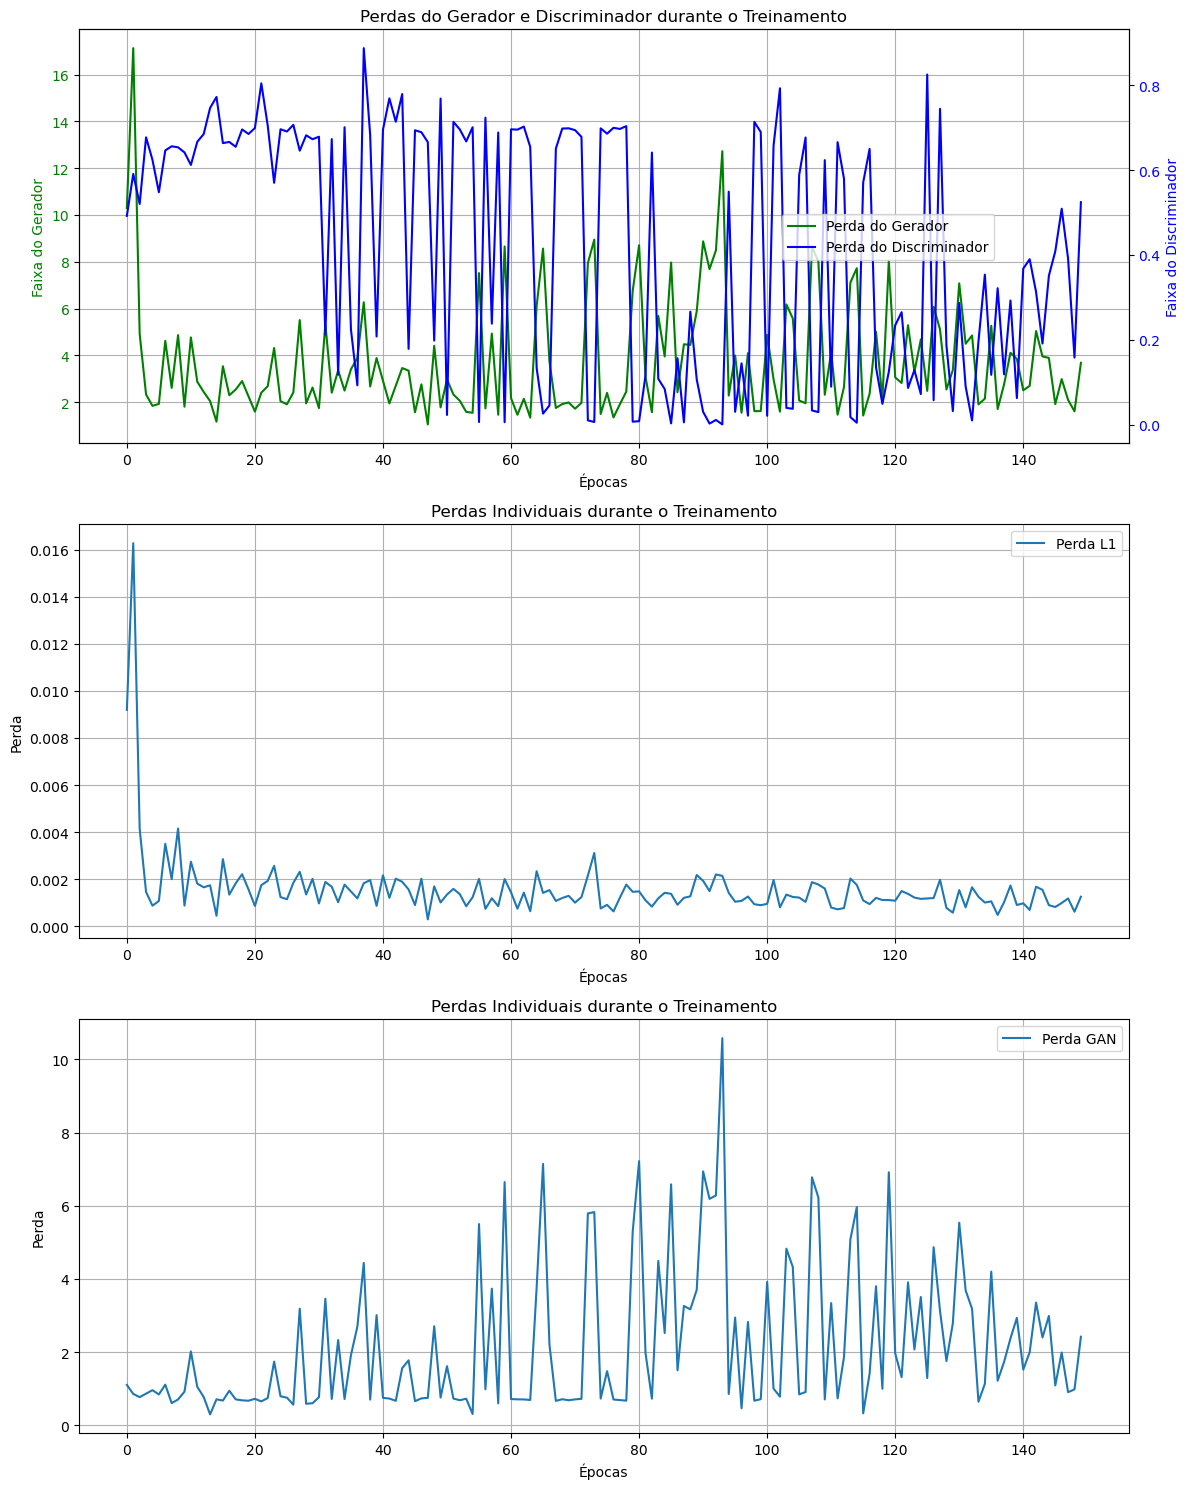

In [17]:
fig, (ax1, ax3, ax4) = plt.subplots(3,1, figsize=(12, 15))  # Definindo um layout de 1 linha e 2 colunas

# Primeiro gráfico: Perdas do Gerador e Discriminador
ax1.plot(G_losses, 'g-', label="Perda do Gerador")
ax1.set_xlabel("Épocas")
ax1.set_ylabel('Faixa do Gerador', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax2 = ax1.twinx()
ax2.plot(D_losses, 'b-', label="Perda do Discriminador")
ax2.set_ylabel('Faixa do Discriminador', color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax1.set_title("Perdas do Gerador e Discriminador durante o Treinamento")
ax1.grid()
fig.legend(loc='upper left',  bbox_to_anchor=(0.65, 0.858))

# Segundo gráfico: Perdas Individuais durante o Treinamento
ax3.plot(L1_losses, label="Perda L1")
ax3.set_xlabel("Épocas")
ax3.set_ylabel("Perda")
ax3.set_title("Perdas Individuais durante o Treinamento")
ax3.grid()
ax3.legend()

ax4.plot(GAN_losses, label="Perda GAN")
ax4.set_xlabel("Épocas")
ax4.set_ylabel("Perda")
ax4.set_title("Perdas Individuais durante o Treinamento")
ax4.grid()
ax4.legend()

# Salvando os gráficos
plt.tight_layout()  # Ajusta automaticamente o espaçamento
plt.savefig('pix2pix_P2VZ_Loss_V5.png')
plt.show()

In [18]:
torch.save({
    'generator_state_dict': G.state_dict(),
    'discriminator_state_dict': D.state_dict(),
    'generator_optimizer_state_dict': optimizer_G.state_dict(),
    'discriminator_optimizer_state_dict': optimizer_D.state_dict(),
    'epoch': epoch
}, 'pix2pix_P2VZcheckpoint_V5.pth')

checkpoint = torch.load('pix2pix_P2VZcheckpoint_V5.pth', weights_only=True)